In [2]:
!if [ -d deepflows ]; then rm -Rf deepflows; fi
!git clone https://github.com/CDGlissov/recurrent-flows-msc.git deepflows
!pip install "./deepflows"

Cloning into 'deepflows'...
remote: Enumerating objects: 154, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (153/153), done.
remote: Total 266 (delta 97), reused 0 (delta 0), pack-reused 112
Receiving objects: 100% (266/266), 1.85 MiB | 14.82 MiB/s, done.
Resolving deltas: 100% (144/144), done.
Processing ./deepflows
  Created wheel for recurrent-flows-msc: filename=recurrent_flows_msc-0.1.0-cp36-none-any.whl size=1121 sha256=26ce05d2dc66de1610321926c00bfd598488b1c17f83f5a02b7a4bac5496481f
  Stored in directory: /tmp/pip-ephem-wheel-cache-xk5o0ypp/wheels/f0/5a/77/8518120597d432632c6abe1aa892d29d8c308fccf620551d65
Successfully built recurrent-flows-msc


In [3]:
from deepflows.data_generators import celeba
from deepflows import utils
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image, make_grid
import IPython
import os
import pandas as pd
from scipy import linalg as la
from math import log, pi, exp
from deepflows.data_generators import stochasticShapes
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
from torchvision import transforms
import torch.distributions as td

device = utils.set_gpu(True)

Note: GPU is available


# Conditional Data

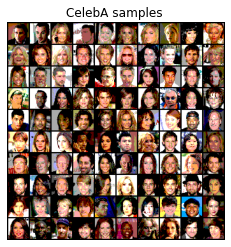

In [4]:
train_data, test_data = celeba.get_celeba(plot_sample=True)

'''
Function transforming CelebA data to conditioned CelebA dataset
'''
def get_joint_conditioned_data(data, box_size = (8, 24)):
  i, j = box_size
  x = data.copy()
  y = data.copy()
  h, w=data.shape[-2:]

  # Set the inner square to 0
  x[:, :, i:j, i:j] = 0
  
  # Set the outer square to 0
  get_ids = np.concatenate((np.arange(0, i, 1),np.arange(j, w, 1)))
  y[:, :, get_ids, :] = 0
  y[:, :, :, get_ids] = 0

  return np.concatenate((x, y), axis=1)

conditioned_train_set = get_joint_conditioned_data(train_data)
conditioned_test_set = get_joint_conditioned_data(test_data)

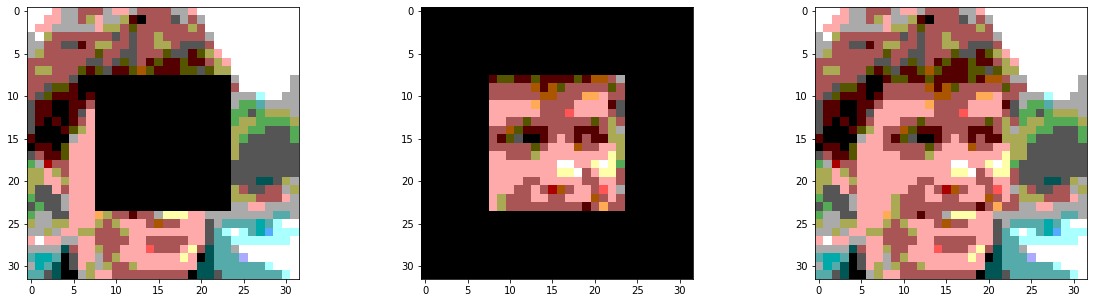

In [5]:
x, y = torch.tensor(conditioned_train_set).split(3, 1)
x = x[8].permute(1, 2, 0)
y = y[8].permute(1, 2, 0)
fig, ax = plt.subplots(1, 3, figsize = (20,5))
ax[0].imshow(x/x.max())
ax[1].imshow(y/y.max())
ax[2].imshow((y+x)/(y+x).max())
plt.show()

# Conditional Glow

#### Nets

In [124]:
class LinearNorm(nn.Linear):
    def __init__(self, in_channels, out_channels):
        super().__init__(in_channels, out_channels)
        self.weight.data.normal_(mean=0.0, std=0.1)
        self.bias.data.normal_(mean=0.0, std=0.1)

class LinearZero(nn.Linear):
    def __init__(self, in_channels, out_channels):
        super().__init__(in_channels, out_channels)
        self.weight.data.zero_()
        self.bias.data.zero_()

class Conv2dResize(nn.Conv2d):

    def __init__(self, in_size, out_size):

        stride = [in_size[1]//out_size[1], in_size[2]//out_size[2]]
        kernel_size = Conv2dResize.compute_kernel_size(in_size, out_size, stride)
        super().__init__(in_channels=in_size[0], out_channels=out_size[0], kernel_size=kernel_size, stride=stride)
        self.weight.data.zero_()


    @staticmethod
    def compute_kernel_size(in_size, out_size, stride):
        k0 = in_size[1] - (out_size[1] - 1) * stride[0]
        k1 = in_size[2] - (out_size[2] - 1) * stride[1]
        return[k0,k1]



class Conv2dZeros(nn.Conv2d):

    def __init__(self, in_channel, out_channel, kernel_size=[3,3], stride=[1,1]):
        padding = (kernel_size[0] - 1) // 2
        super().__init__(in_channels=in_channel, out_channels=out_channel, kernel_size=kernel_size, stride=stride, padding=padding)
        self.weight.data.normal_(mean=0.0, std=0.1)



class Conv2dResize(nn.Conv2d):

    def __init__(self, in_size, out_size):

        stride = [in_size[1]//out_size[1], in_size[2]//out_size[2]]
        kernel_size = Conv2dResize.compute_kernel_size(in_size, out_size, stride)
        super().__init__(in_channels=in_size[0], out_channels=out_size[0], kernel_size=kernel_size, stride=stride)
        self.weight.data.zero_()


    @staticmethod
    def compute_kernel_size(in_size, out_size, stride):
        k0 = in_size[1] - (out_size[1] - 1) * stride[0]
        k1 = in_size[2] - (out_size[2] - 1) * stride[1]
        return[k0,k1]



class LinearZeros(nn.Linear):

    def __init__(self, in_channels, out_channels):
        super().__init__(in_channels, out_channels)
        self.weight.data.zero_()
        self.bias.data.zero_()

    def forward(self, input):
        output = super().forward(input)
        return output


class LinearNorm(nn.Linear):

    def __init__(self, in_channels, out_channels):
        super().__init__(in_channels, out_channels)
        self.weight.data.normal_(mean=0.0, std=0.1)
        self.bias.data.normal_(mean=0.0, std=0.1)

class ConditionNet(nn.Module):
    def __init__(self, in_channels, output_channels, height, width, hid_dim = 32, weight_layer=False):
        """
        A condition net. It takes in and out channels as input.
        Output is x, it is usually used to estimate the parameters for the affine transformation, hence
        the output dimensions are usually multiplied by 2, as we need two parameters.
        """
        super(ConditionNet, self).__init__()
        layers = [WeightNormConv2d(in_channels, 128, (2, 2), stride=2, padding= 0 ),
                  nn.ReLU(),
                  WeightNormConv2d(128, 128, (2, 2), stride=2, padding=0),
                  nn.ReLU(),
                  WeightNormConv2d(128, in_channels, (2, 2), stride=2, padding=0),
                  nn.ReLU()]
        h, w = utils.get_layer_size([height, width], kernels=[2, 2, 2], paddings=[0, 0, 0], strides=[2, 2, 2],
                                    dilations=[1, 1, 1])
        self.net = nn.Sequential(*layers)
        layers_flatten = [LinearZero(h * w * (in_channels), 32), nn.ReLU(), LinearZero(32, 32), nn.ReLU()]

        if weight_layer == True:
          layers_flatten.append(LinearNorm(32, output_channels))
        else:
          layers_flatten.append(LinearZero(32, output_channels))
        
        layers_flatten.append(nn.Tanh())

        self.net_flatten = nn.Sequential(*layers_flatten)

        self.apply(self.initialize_weights)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.net(x)
        x = x.view(batch_size, -1)
        x = self.net_flatten(x)
        x = x.view(batch_size, -1, 1, 1)
        return x

    def initialize_weights(self, layer):
      if type(layer) == nn.Conv2d:
        layer.weight.data.zero_()

# Glow functions

In [279]:
def split_feature(tensor, type="split"):
    C = tensor.size(1)
    if type == "split":
        return tensor[:, :C // 2, ...], tensor[:, C // 2:, ...]
    elif type == "cross":
        return tensor[:, 0::2, ...], tensor[:, 1::2, ...]



class ConditionalActNorm(nn.Module):
    def __init__(self, x_size, condition_size):
        """
        Applied conditional ActNorm, finds the conditional shift. From the condition.
        """
        super(ConditionalActNorm, self).__init__()
        Bx, Cx, self.Hx, self.Wx = x_size
        B, C, self.H, self.W = condition_size

        x_hidden_channels = 128
        x_hidden_size = 64
        self.ConditionalNet = nn.Sequential(
            Conv2dResize(in_size=[C, self.H, self.W], out_size=[x_hidden_channels, self.H//2, self.W//2]),
            nn.ReLU(),
            Conv2dResize(in_size=[x_hidden_channels, self.H//2, self.W//2], out_size=[x_hidden_channels, self.H//4, self.W//4]),
            nn.ReLU(),
            Conv2dResize(in_size=[x_hidden_channels, self.H//4, self.W//4], out_size=[x_hidden_channels, self.H//8, self.W//8]),
            nn.ReLU()
        )
        
        self.ConditionalNet_Linear = nn.Sequential(
            LinearZeros(x_hidden_channels*self.H*self.W//(8*8), x_hidden_size),
            nn.ReLU(),
            LinearZeros(x_hidden_size, x_hidden_size),
            nn.ReLU(),
            LinearZeros(x_hidden_size, 2*Cx),
            nn.Tanh()
        )
        
    def forward(self, x, condition, logdet = 0.0, reverse=False):
        bs = x.shape[0]
        output = self.ConditionalNet(condition)
        output=output.view(bs, -1)
        output=self.ConditionalNet_Linear(output).view(bs, -1, 1, 1)
        
        log_scale, shift = split_feature(output)


        dlogdet = self.Hx * self.Wx * torch.sum(log_scale, dim=(1,2,3))

        if reverse == False:
            logdet += dlogdet
            x = x + shift
            x = x * torch.exp(log_scale)
            return x, logdet
        else:
            logdet -= dlogdet
            x = x * torch.exp(-log_scale)
            x = x - shift
            return x, logdet


class ConditionalInvConv(nn.Module):
    def __init__(self, x_size, condition_size):
        super(ConditionalInvConv, self).__init__()

        Bx, Cx, self.Hx, self.Wx = x_size
        B, C, self.H, self.W = condition_size
        
        x_hidden_channels = 128
        x_hidden_size = 64
        self.ConditionalNet = nn.Sequential(
            Conv2dResize(in_size=[C, self.H, self.W], out_size=[x_hidden_channels, self.H//2, self.W//2]),
            nn.ReLU(),
            Conv2dResize(in_size=[x_hidden_channels, self.H//2, self.W//2], out_size=[x_hidden_channels, self.H//4, self.W//4]),
            nn.ReLU(),
            Conv2dResize(in_size=[x_hidden_channels, self.H//4, self.W//4], out_size=[x_hidden_channels, self.H//8, self.W//8]),
            nn.ReLU()
        )

        self.ConditionalNet_Linear = nn.Sequential(
            LinearZeros(x_hidden_channels*self.H*self.W//(8*8), x_hidden_size),
            nn.ReLU(),
            LinearZeros(x_hidden_size, x_hidden_size),
            nn.ReLU(),
            LinearNorm(x_hidden_size, Cx*Cx),
            nn.Tanh()
        )

    def forward(self, x, condition, logdet = None, reverse=False):

        Bx, Cx, Hx, Wx = x.size()
        B, C, H, W = condition.size()


        bs = x.shape[0]
        W = self.ConditionalNet(condition)
        W=W.view(bs, -1)
        W=self.ConditionalNet_Linear(W).view(bs, Cx, Cx, 1)

        W = W.view(Bx, Cx, Cx)
        

        dlogdet = Hx*Wx*torch.slogdet(W)[1]

        if reverse == False:
            W = W.view(Bx, Cx, Cx, 1, 1)
        else:
            W = torch.inverse(W.double()).float().view(Bx, Cx, Cx, 1, 1)
        
        x = x.view(1, Bx*Cx, Hx, Wx)
        B_weight, C_1_weight, C_2_weight, H_weight, W_weight = W.shape
        W = W.reshape(B_weight*C_1_weight, C_2_weight, H_weight, W_weight)

        if reverse == False:
          x = F.conv2d(x, W, groups=Bx)
          x = x.view(Bx,Cx,Hx,Wx)
          logdet += dlogdet
        else:
          x = F.conv2d(x, W, groups=Bx)
          x = x.view(Bx,Cx,Hx,Wx)
          logdet -= dlogdet
        return x, logdet


class ActNorm(nn.Module):

    def __init__(self, num_channels):
        super().__init__()

        size = [1, num_channels, 1, 1]

        bias = torch.normal(mean=torch.zeros(*size), std=torch.ones(*size)*0.05)
        logs = torch.normal(mean=torch.zeros(*size), std=torch.ones(*size)*0.05)
        self.register_parameter("bias", nn.Parameter(torch.Tensor(bias), requires_grad=True))
        self.register_parameter("logs", nn.Parameter(torch.Tensor(logs), requires_grad=True))


    def forward(self, input, logdet=0, reverse=False):
        dims = input.size(2) * input.size(3)
        if reverse == False:
            input = input + self.bias
            input = input * torch.exp(self.logs)
            dlogdet = torch.sum(self.logs) * dims
            logdet = logdet + dlogdet

        if reverse == True:
            input = input * torch.exp(-self.logs)
            input = input - self.bias
            dlogdet = - torch.sum(self.logs) * dims
            logdet = logdet + dlogdet

        return input, logdet

class Conv2dNormy(nn.Conv2d):

    def __init__(self, in_channels, out_channels,
                 kernel_size=[3, 3], stride=[1, 1]):
        padding = [(kernel_size[0]-1)//2, (kernel_size[1]-1)//2]
        super().__init__(in_channels, out_channels, kernel_size, stride,
                         padding, bias=False)

        #initialize weight
        self.weight.data.normal_(mean=0.0, std=0.05)
        self.actnorm = ActNorm(out_channels)


    def forward(self, input):
        x = super().forward(input)
        x,_ = self.actnorm(x)
        return x

class Conv2dZerosy(nn.Conv2d):

    def __init__(self, in_channels, out_channels,
                 kernel_size=[3, 3], stride=[1, 1]):

        padding = [(kernel_size[0]-1)//2, (kernel_size[1]-1)//2]
        super().__init__(in_channels, out_channels, kernel_size, stride, padding)

        self.logscale_factor = 3.0
        self.register_parameter("logs", nn.Parameter(torch.zeros(out_channels, 1, 1)))
        self.register_parameter("newbias", nn.Parameter(torch.zeros(out_channels, 1, 1)))

        # init
        self.weight.data.zero_()
        self.bias.data.zero_()

    def forward(self, input):
        output = super().forward(input)
        output = output + self.newbias
        output = output * torch.exp(self.logs * self.logscale_factor)
        return output


class ConditionalAffineCoupling(nn.Module):
    def __init__(self, x_size, condition_size):
        super(ConditionalAffineCoupling, self).__init__()
        
        Bx, Cx, Hx, Wx = x_size
        B, C, H, W = condition_size
        stride = [H//Hx, W//Wx]
        kernel = [H - (Hx - 1) * stride[0], W - (Wx - 1) * stride[1]]
        
        hidden_channels = 256

        self.resize = nn.Sequential(
            Conv2dZeros(C, 16),
            nn.ReLU(),
            Conv2dResize((16, H, W), out_size=(Cx, Hx, Wx)),
            nn.ReLU(),
            Conv2dZeros(Cx, Cx//2),
            nn.ReLU()
        )

        self.f = nn.Sequential(
            Conv2dNormy(Cx, hidden_channels),
            nn.ReLU(),
            Conv2dNormy(hidden_channels, hidden_channels, kernel_size=[1, 1]),
            nn.ReLU(),
            Conv2dZerosy(hidden_channels, Cx),
            nn.Tanh()
        )

    def forward(self, x, condition, logdet=0.0, reverse=False):
        
        z1, z2 = split_feature(x, "split")
        condition = self.resize(condition)
        x = torch.cat((z1, condition), dim=1)
        
        x = self.f(x)

        scale, shift = split_feature(x, "cross")
        scale = torch.sigmoid(scale + 2.)

        if reverse == False:
            z2 = z2 + shift
            z2 = z2 * scale
            logdet += torch.sum(torch.log(scale), dim=(1, 2, 3))
        else:
            z2 = z2 / scale
            z2 = z2 - shift
            logdet -= torch.sum(torch.log(scale), dim=(1, 2, 3)) 

        x = torch.cat((z1, z2), dim=1)
        return x, logdet


class GlowStep(nn.Module):
    def __init__(self, x_size, condition_size):
      super(GlowStep, self).__init__()
            
      self.actnorm = ConditionalActNorm(x_size, condition_size)
      self.invconv =  ConditionalInvConv(x_size, condition_size)
      self.affine =  ConditionalAffineCoupling(x_size, condition_size)
       

    def forward(self, x, condition, logdet=None, reverse=False):
        if reverse == False:
            x, logdet = self.actnorm(x, condition, logdet, reverse=False)
            x, logdet = self.invconv(x, condition, logdet, reverse=False)
            x, logdet = self.affine(x, condition, logdet, reverse=False)
            return x, logdet #z here
        else:
            x, logdet = self.affine(x, condition, logdet, reverse=True)
            x, logdet = self.invconv(x, condition, logdet, reverse=True)
            x, logdet = self.actnorm(x, condition, logdet, reverse=True)
            return x, logdet

class Squeeze2d(nn.Module):
    def __init__(self):
        super(Squeeze2d, self).__init__()
        
    def forward(self, x, undo_squeeze = False):
      B, C, H, W = x.shape
      if undo_squeeze == False:
        # C x H x W -> 4C x H/2 x W/2
        x = x.reshape(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C * 4, H // 2, W // 2)
      else:
        # 4C x H/2 x W/2  ->  C x H x W
        x = x.reshape(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C // 4, H * 2, W * 2)
      return x

class Split2d(nn.Module):
    def __init__(self, x_size):
      super(Split2d, self).__init__()

      Bx, Cx, Hx, Wx = x_size
      self.conv = nn.Sequential(
          Conv2dZeros(Cx // 2, Cx),
          nn.Tanh()
          )
      

    def forward(self, x, logdet=0.0, reverse=False):
        
        
        if reverse == False:
            z1, z2 = split_feature(x, "split")
            out = self.conv(z1)
            mean, log_scale = split_feature(out, "cross")
            logdet += torch.sum(td.Normal(mean, torch.exp(log_scale)).log_prob(z2), dim=(1,2,3))
            return z1, logdet
        else:
            mean, log_scale = split_feature(self.conv(x), "cross")
            z2 = td.Normal(mean, torch.exp(log_scale)).rsample()
            z = torch.cat((x, z2), dim=1)
            return z, logdet

class GlowConditional(nn.Module):
    def __init__(self, x_size, condition_size, K = 4, L = 2, learn_prior = True):
        super(GlowConditional, self).__init__()

        self.L = L
        self.K = K
        Bx, Cx, Hx, Wx = x_size
        B, C, H, W = condition_size
        
        layers = []

        # Set up structure
        for l in range(0, L):
            Cx, Hx, Wx = Cx * 4, Hx // 2, Wx // 2
            x_size =  [Bx, Cx, Hx, Wx]
            layers.append(Squeeze2d())

            for i in range(0, K):
                layers.append(GlowStep(x_size, condition_size))
            
            if l < (L-1):
                layers.append(Split2d(x_size)) 
                Cx = Cx // 2 
                x_size = [Bx, Cx, Hx, Wx]

        self.glow_frame = nn.ModuleList(layers)

        self.learn_prior = learn_prior
        if learn_prior:
          self.new_mean = nn.Parameter(torch.zeros([Cx, Hx, Wx])).to(device)
          self.new_logs = nn.Parameter(torch.zeros([Cx, Hx, Wx])).to(device)
        else:
          self.new_mean = torch.zeros([Cx, Hx, Wx]).to(device)
          self.new_logs = torch.zeros([Cx, Hx, Wx]).to(device)

    def set_prior(self):
        return self.new_mean, torch.exp(self.new_logs)

    def g(self, z, condition, logdet=0.0):
        # maps z -> x
        x=z
        for step in reversed(self.glow_frame):
          if isinstance(step, Squeeze2d):
            x = step(x, undo_squeeze=True)
          elif isinstance(step, Split2d):
            x, _ = step(x, logdet = logdet, reverse=True)
          else:
            x, _ = step(x, condition=condition, logdet = logdet, reverse=True)
        return x, logdet

    def f(self, x, condition, logdet=0.0):
        # maps x -> z
        z = x
        for step in self.glow_frame:
            if isinstance(step, Squeeze2d):
                z = step(z)
            elif isinstance(step, Split2d):
                z, logdet = step(z, logdet=logdet, reverse=False)
            else:
                z, logdet = step(z, condition=condition, logdet=logdet, reverse=False)
        return z, logdet
    
    def log_prob(self, x, condition):
        #x, nll_discretization = self.uniform_binning_correction(x)
        #condition, _ = self.uniform_binning_correction(condition)
        dims = torch.prod(torch.tensor(x.shape[1:]))
        z, obj = self.f(x, condition, 0.0)
        mean, scale = self.set_prior()
        prior = td.Normal(mean, scale)
        obj += torch.sum(prior.log_prob(z), [1, 2, 3]) #p_z
        obj = torch.mean(obj)
        nll = -(obj) / float(np.log(2.) * dims) #+ nll_discretization.mean(0)
        return z, nll

    def sample(self, z, condition, num_samples):
        with torch.no_grad():
          mean, scale = self.set_prior()
          prior = td.Normal(mean, scale)
          if z == None:
            z = prior.sample([num_samples]).to(device)
          x, logdet = self.g(z, condition)
        return x, logdet

    def uniform_binning_correction(self, x, n_bits=8):
      n_bins = 2**n_bits
      batch_size, n_channels, height, width = x.shape
      hwc = float(height * width * n_channels)

      x += torch.distributions.Uniform(0.0, 1/2).sample(x.shape).to(device)
      objective = -(np.log(1/n_bins) / hwc ) * torch.ones(batch_size).to(device)
      return x, objective

# Trainer

In [300]:
batch_size = 32
class Solver(object):
    def __init__(self, learning_rate=5e-4, n_epochs=128):
        self.train_loader, self.val_loader = self.create_loaders()
        self.n_epochs = n_epochs
        self.learning_rate = learning_rate
        self.n_batches_in_epoch = len(self.train_loader)

    def build(self):
        #change here for new input
        self.flow = GlowConditional((batch_size, 3, 32, 32), (batch_size, 3, 32, 32), K=4, L=2, learn_prior = False).to(device)
        self.optimizer = torch.optim.Adam(self.flow.parameters(), lr=self.learning_rate)

    def create_loaders(self):
        train_loader = torch.utils.data.DataLoader(conditioned_train_set, batch_size=batch_size, shuffle=True)
        test_loader = torch.utils.data.DataLoader(conditioned_test_set, batch_size=batch_size, shuffle=False)
        return train_loader, test_loader

    # check if this is correct
    def preprocess(self, x, reverse=False, dequantization = False, n_bits = 8):
        batch_size, n_channels, height, width = x.shape
        hwc = float(height * width * n_channels)
        objective = 0
        if reverse:
            x = 1.0 / (1 + torch.exp(-x))
            x -= 0.05
            x /= 0.9
            return x
        else:
            if dequantization == True:
              n_bins = 2**n_bits
              x += torch.distributions.Uniform(0.0, 1/2).sample(x.shape).to(device)
              objective += torch.mean(-(np.log(1/n_bins) / hwc ) * torch.ones(batch_size).to(device))
              max_value = 3.0 + 1/2
            else:
              max_value = 3.0
            x /= max_value

            # Taking into account boundary
            x *= 0.9
            x += 0.05

            #Logit operation
            logit = torch.log(x) - torch.log(1.0 - x)
            
            log_det = torch.nn.functional.softplus(logit) + torch.nn.functional.softplus(-logit) \
                      + torch.log(torch.tensor(0.9)) - torch.log(torch.tensor(max_value))

            objective += torch.mean(torch.sum(log_det, dim=(1, 2, 3))) / float(np.log(2.) *hwc)
            return logit, objective


    def train(self):
        train_losses = []
        val_losses = []
        for epoch_i in range(self.n_epochs):
            epoch_i += 1

            self.flow.train()
            self.batch_loss_history = []

            for batch_i, image in enumerate(tqdm(
                    self.train_loader, desc='Batch', leave=False)):

                batch_i += 1
                image = Variable(image).to(device)

                logit_x, log_det = self.preprocess(image.float(), dequantization=True)
                condition, logit_x = logit_x.split(3, 1)
                
                z, log_prob = self.flow.log_prob(logit_x, condition)
                log_prob += log_det
                

                batch_loss = torch.mean(log_prob)

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()
                batch_loss = float(batch_loss.data)
                self.batch_loss_history.append(batch_loss)

            epoch_loss = np.mean(self.batch_loss_history)
            tqdm.write(f'Epoch {epoch_i} Loss: {epoch_loss:.2f}')

            if epoch_i % 75 == 0:
                self.save_model("GlowConditional{}.model".format(str(epoch_i)))
            train_losses.append(epoch_loss)

        return train_losses

    def validate(self):
      return "Not Yet Implemented"

    def save_model(self, filename):
        torch.save(self.flow, filename)

    def load_model(self, filename):
        self.flow = torch.load(filename, map_location="cpu")

# Execution

In [301]:
solver = Solver(n_epochs=30, learning_rate=0.001)
solver.build()
train = solver.train()

Epoch 1 Loss: 4.33


Epoch 2 Loss: 2.03


Epoch 3 Loss: 1.99


Epoch 4 Loss: 1.97


Epoch 5 Loss: 1.94


Epoch 6 Loss: 1.93


Epoch 7 Loss: 1.91


Epoch 8 Loss: 1.90


Epoch 9 Loss: 1.89


Epoch 10 Loss: 1.87


Epoch 11 Loss: 1.87


Epoch 12 Loss: 1.86


Epoch 13 Loss: 1.85


Epoch 14 Loss: 1.85


Epoch 15 Loss: 1.84


Epoch 16 Loss: 1.84


Epoch 17 Loss: 1.84


Epoch 18 Loss: 1.84


Epoch 19 Loss: 1.83


Epoch 20 Loss: 1.83


Epoch 21 Loss: 1.83


Epoch 22 Loss: 1.83


Epoch 23 Loss: 1.83


Epoch 24 Loss: 1.83


Epoch 25 Loss: 1.83


Epoch 26 Loss: 1.82


Epoch 27 Loss: 1.82


Epoch 28 Loss: 1.82


Epoch 29 Loss: 1.82


Epoch 30 Loss: 1.82


# Sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


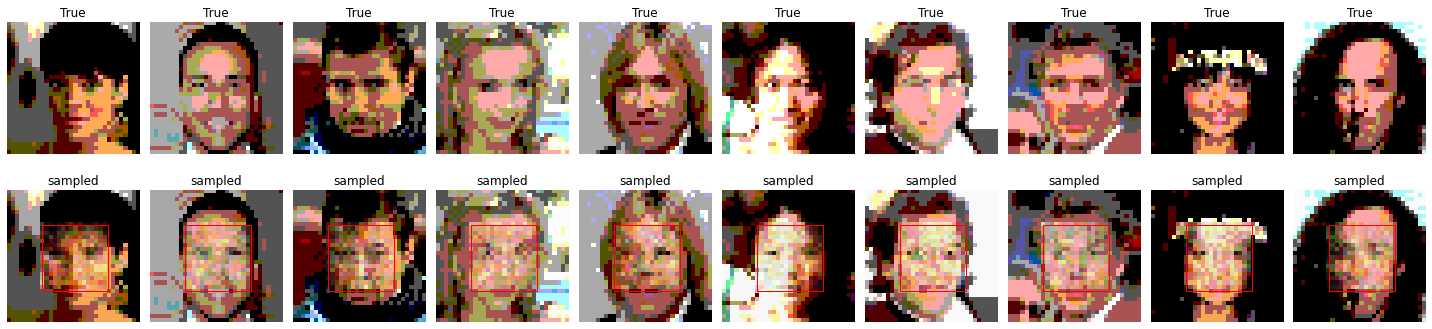

In [302]:
import matplotlib.patches as patches
test_loader = torch.utils.data.DataLoader(conditioned_test_set, batch_size=batch_size, shuffle=False, pin_memory=False)
x=next(iter(test_loader)).to(device)
solver.flow.eval()

#Preprocess
x, log_det = solver.preprocess(x)
condition_x, x = x.split(3, dim=1)

with torch.no_grad():
  samples, log_det=solver.flow.sample(z=None, condition=condition_x.to(device), num_samples=32)
  

# Preprocess samples
samples = solver.preprocess(samples, reverse=True)
conzre = solver.preprocess(condition_x, reverse=True)
zre = solver.preprocess(x, reverse=True)


fig, axes = plt.subplots(2, 10 , figsize = (20,5))

j=0
k=0
for i in range(0, 10):
  img_1 = ((conzre[i]+zre[i])/4*4)
  
  axes[k*2, j].imshow(img_1.div(img_1.max()).permute(1,2,0).detach().cpu().numpy())
  axes[k*2, j].set_title('True')
  axes[k*2, j].set_axis_off()
  kk = conzre[i]
  kk[:,8:24,8:24] = samples[i,:,8:24,8:24]
  axes[k*2+1, j].imshow((kk.div(kk.max())).permute(1,2,0).detach().cpu().numpy())
  axes[k*2+1, j].set_title('sampled')
  axes[k*2+1, j].set_axis_off()
  rect = patches.Rectangle((8,8),24-8,24-8,linewidth=1,edgecolor='r',facecolor='none')
  axes[k*2+1, j].add_patch(rect)
  k+=1
  if k*2 % 2 == 0:
    j += 1
    k = 0

fig.tight_layout()

In [ ]:
Testermore=GlowConditional(x_size=[64,4,16,16], condition_size=[64,4,16,16], L=1, K=4, learn_prior=True)
xtest=torch.rand(64,4,16,16)
z,__=Testermore.f(xtest,xtest,logdet=0)
xnew,__=Testermore.g(z,xtest,logdet=0)
#z,__=Testermore(xtest,xtest,logdet=0,reverse=False)
#xnew,__=Testermore(z,xtest,logdet=0, reverse=True)
for i in range(0,4):
  plt.figure()
  plt.subplot(1,3,1)
  plt.imshow(xtest[0][i].squeeze().detach())
  plt.subplot(1,3,2)
  plt.imshow(xnew[0][i].squeeze().detach())
  plt.subplot(1,3,3)
  plt.imshow((xtest[0][i]-xnew[0][i]).squeeze().detach())
  print((xtest[0][i]-xnew[0][i]).sum())

In [ ]:
class Gaussian:
  @staticmethod
  def log_prob(mean, logs, x):
    ll = -0.5 * (logs * 2.0 + ((x - mean) ** 2) / torch.exp(logs * 2.0) + math.log(2 * math.pi))
    return torch.sum(ll, dim=[1, 2, 3])

  @staticmethod
  def sample(mean, logs, temperature=1):
    z = torch.normal(mean, torch.exp(logs) * temperature)
    return z

In [98]:


def split_feature(tensor, type="split"):
    C = tensor.size(1)
    if type == "split":
        return tensor[:, :C // 2, ...], tensor[:, C // 2:, ...]
    elif type == "cross":
        return tensor[:, 0::2, ...], tensor[:, 1::2, ...]



class ConditionalActNorm(nn.Module):
    def __init__(self, x_size, condition_size):
        """
        Applied conditional ActNorm, finds the conditional shift. From the condition.
        """
        super(ConditionalActNorm, self).__init__()
        Bx, Cx, self.Hx, self.Wx = x_size
        B, C, self.H, self.W = condition_size

        self.ConditionalNet = ConditionNet(in_channels = C, output_channels = 2 * Cx, 
                                           height = self.H, width = self.H)
        
    def forward(self, x, condition, logdet = 0.0, reverse=False):
  
        output = self.ConditionalNet(condition)

        log_scale, shift = split_feature(output)
        #scale=torch.sigmoid(scale + 2.)
        #log_scale = torch.log(scale)

        dlogdet = self.Hx * self.Wx * torch.sum(log_scale, dim=(1,2,3))

        if reverse == False:
            logdet += dlogdet
            x = x + shift
            x = x * torch.exp(log_scale)
            return x, logdet
        else:
            logdet -= dlogdet
            x = x * torch.exp(-log_scale)
            x = x - shift
            return x, logdet


class ConditionalInvConv(nn.Module):
    def __init__(self, x_size, condition_size):
        super(ConditionalInvConv, self).__init__()

        Bx, Cx, self.Hx, self.Wx = x_size
        B, C, self.H, self.W = condition_size
        
        self.ConditionalNet = ConditionNet(in_channels = C, output_channels= Cx * Cx, height = self.H, width = self.H, weight_layer=True)
    
    def forward(self, x, condition, logdet = None, reverse=False):

        Bx, Cx, Hx, Wx = x.size()
        B, C, H, W = condition.size()

        W = self.ConditionalNet(condition)
        W = W.view(Bx, Cx, Cx)
        

        dlogdet = Hx*Wx*torch.slogdet(W)[1]

        if reverse == False:
            W = W.view(Bx, Cx, Cx, 1, 1)
        else:
            W = torch.inverse(W.double()).float().view(Bx, Cx, Cx, 1, 1)
        
        x = x.view(1, Bx*Cx, Hx, Wx)
        B_weight, C_1_weight, C_2_weight, H_weight, W_weight = W.shape
        W = W.reshape(B_weight*C_1_weight, C_2_weight, H_weight, W_weight)

        if reverse == False:
          x = F.conv2d(x, W, groups=Bx)
          x = x.view(Bx,Cx,Hx,Wx)
          logdet += dlogdet
        else:
          x = F.conv2d(x, W, groups=Bx)
          x = x.view(Bx,Cx,Hx,Wx)
          logdet -= dlogdet
        return x, logdet


class ActNorm(nn.Module):

    def __init__(self, num_channels):
        super().__init__()

        size = [1, num_channels, 1, 1]

        bias = torch.normal(mean=torch.zeros(*size), std=torch.ones(*size)*0.05)
        logs = torch.normal(mean=torch.zeros(*size), std=torch.ones(*size)*0.05)
        self.register_parameter("bias", nn.Parameter(torch.Tensor(bias), requires_grad=True))
        self.register_parameter("logs", nn.Parameter(torch.Tensor(logs), requires_grad=True))


    def forward(self, input, logdet=0, reverse=False):
        dims = input.size(2) * input.size(3)
        if reverse == False:
            input = input + self.bias
            input = input * torch.exp(self.logs)
            dlogdet = torch.sum(self.logs) * dims
            logdet = logdet + dlogdet

        if reverse == True:
            input = input * torch.exp(-self.logs)
            input = input - self.bias
            dlogdet = - torch.sum(self.logs) * dims
            logdet = logdet + dlogdet

        return input, logdet

class Conv2dNormy(nn.Conv2d):

    def __init__(self, in_channels, out_channels,
                 kernel_size=[3, 3], stride=[1, 1]):
        padding = [(kernel_size[0]-1)//2, (kernel_size[1]-1)//2]
        super().__init__(in_channels, out_channels, kernel_size, stride,
                         padding, bias=False)

        #initialize weight
        self.weight.data.normal_(mean=0.0, std=0.05)
        self.actnorm = ActNorm(out_channels)


    def forward(self, input):
        x = super().forward(input)
        x,_ = self.actnorm(x)
        return x

class Conv2dZerosy(nn.Conv2d):

    def __init__(self, in_channels, out_channels,
                 kernel_size=[3, 3], stride=[1, 1]):

        padding = [(kernel_size[0]-1)//2, (kernel_size[1]-1)//2]
        super().__init__(in_channels, out_channels, kernel_size, stride, padding)

        self.logscale_factor = 3.0
        self.register_parameter("logs", nn.Parameter(torch.zeros(out_channels, 1, 1)))
        self.register_parameter("newbias", nn.Parameter(torch.zeros(out_channels, 1, 1)))

        # init
        self.weight.data.zero_()
        self.bias.data.zero_()

    def forward(self, input):
        output = super().forward(input)
        output = output + self.newbias
        output = output * torch.exp(self.logs * self.logscale_factor)
        return output


class ConditionalAffineCoupling(nn.Module):
    def __init__(self, x_size, condition_size):
        super(ConditionalAffineCoupling, self).__init__()
        
        Bx, Cx, Hx, Wx = x_size
        B, C, H, W = condition_size
        stride = [H//Hx, W//Wx]
        kernel = [H - (Hx - 1) * stride[0], W - (Wx - 1) * stride[1]]
        
        self.resize = nn.Sequential(
            nn.Conv2d(in_channels = C, out_channels = 128, kernel_size=3, stride=1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 128, kernel_size=kernel, stride=stride, padding = 0),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = Cx // 2, kernel_size=3, stride=1, padding = 1),
            nn.ReLU(),
        )

        hidden_channels = 64
        self.f = nn.Sequential(
            Conv2dNormy(Cx, hidden_channels),
            nn.ReLU(),
            Conv2dNormy(hidden_channels, hidden_channels, kernel_size=[1, 1]),
            nn.ReLU(),
            Conv2dZerosy(hidden_channels, Cx),
            nn.Tanh()
        )

    def forward(self, x, condition, logdet=0.0, reverse=False):
        
        z1, z2 = split_feature(x, "split")
        condition = self.resize(condition)
        x = torch.cat((z1, condition), dim=1)
        
        x = self.f(x)

        scale, shift = split_feature(x, "cross")
        scale = torch.sigmoid(scale + 2.)

        if reverse == False:
            z2 = z2 + shift
            z2 = z2 * scale
            logdet += torch.sum(torch.log(scale), dim=(1, 2, 3))
        else:
            z2 = z2 / scale
            z2 = z2 - shift
            logdet -= torch.sum(torch.log(scale), dim=(1, 2, 3)) 

        x = torch.cat((z1, z2), dim=1)
        return x, logdet


class GlowStep(nn.Module):
    def __init__(self, x_size, condition_size):
      super(GlowStep, self).__init__()
            
      self.actnorm = ConditionalActNorm(x_size, condition_size)
      self.invconv =  ConditionalInvConv(x_size, condition_size)
      self.affine =  ConditionalAffineCoupling(x_size, condition_size)
       

    def forward(self, x, condition, logdet=None, reverse=False):
        if reverse == False:
            x, logdet = self.actnorm(x, condition, logdet, reverse=False)
            x, logdet = self.invconv(x, condition, logdet, reverse=False)
            x, logdet = self.affine(x, condition, logdet, reverse=False)
            return x, logdet #z here
        else:
            x, logdet = self.affine(x, condition, logdet, reverse=True)
            x, logdet = self.invconv(x, condition, logdet, reverse=True)
            x, logdet = self.actnorm(x, condition, logdet, reverse=True)
            return x, logdet

class Squeeze2d(nn.Module):
    def __init__(self):
        super(Squeeze2d, self).__init__()
        
    def forward(self, x, undo_squeeze = False):
      B, C, H, W = x.shape
      if undo_squeeze == False:
        # C x H x W -> 4C x H/2 x W/2
        x = x.reshape(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C * 4, H // 2, W // 2)
      else:
        # 4C x H/2 x W/2  ->  C x H x W
        x = x.reshape(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C // 4, H * 2, W * 2)
      return x

class Conv2dZeros(nn.Module):
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size=(3, 3),
        stride=(1, 1),
        padding = None,
        logscale_factor=3,
    ):
        super().__init__()

        if padding == None: 
          padding = [((k - 1) * s + 1) // 2 for k, s in zip(kernel_size, stride)]

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

        self.conv.weight.data.zero_()
        self.conv.bias.data.zero_()

        self.logscale_factor = logscale_factor
        self.logs = nn.Parameter(torch.zeros(out_channels, 1, 1))

    def forward(self, input):
        output = self.conv(input)
        return output * torch.exp(self.logs * self.logscale_factor)

class Split2d(nn.Module):
    def __init__(self, x_size):
      super(Split2d, self).__init__()

      Bx, Cx, Hx, Wx = x_size
      self.conv = nn.Sequential(
          #Conv2dZeros(Cx // 2, Cx),
          Conv2d(Cx // 2, Cx, 3, 1, 0),
          nn.Tanh()
          )
      

    def forward(self, x, logdet=0.0, reverse=False):
        
        
        if reverse == False:
            z1, z2 = split_feature(x, "split")
            out = self.conv(z1)
            mean, log_scale = split_feature(out, "cross")
            logdet += torch.sum(td.Normal(mean, torch.exp(log_scale)).log_prob(z2), dim=(1,2,3))
            return z1, logdet
        else:
            mean, log_scale = split_feature(self.conv(x), "cross")
            z2 = td.Normal(mean, torch.exp(log_scale)).rsample()
            z = torch.cat((x, z2), dim=1)
            return z, logdet


class GlowConditional(nn.Module):
    def __init__(self, x_size, condition_size, K = 4, L = 2, learn_prior = True):
        super(GlowConditional, self).__init__()

        self.L = L
        self.K = K
        self.Bx, Cx, Hx, Wx = x_size
        B, C, H, W = condition_size
        
        layers = []

        # Set up structure
        for l in range(0, L):
            Cx, Hx, Wx = Cx * 4, Hx // 2, Wx // 2
            x_size =  [self.Bx, Cx, Hx, Wx]
            layers.append(Squeeze2d())

            for i in range(0, K):
                layers.append(GlowStep(x_size, condition_size))
            
            if l < (L-1):
                layers.append(Split2d(x_size)) 
                Cx = Cx // 2 
                x_size = [self.Bx, Cx, Hx, Wx]

        self.glow_frame = nn.ModuleList(layers)

        self.learn_prior = learn_prior
        if self.learn_prior:
          self.learn_top = Conv2dZeros(2*Cx, 2*Cx)
          stride = [H//Hx, W//Wx]
          kernel = [H - (Hx - 1) * stride[0], W - (Wx - 1) * stride[1]]
          self.learn_top_cond = Conv2dZeros(C, 2*Cx, kernel_size=kernel, stride=stride, padding=0)
          self.register_buffer("prior_est", torch.zeros([1, 2*Cx, Hx, Wx]))
        else:
          self.new_mean = torch.zeros([self.Bx, Cx, Hx, Wx]).to(device)
          self.new_logs = torch.zeros([self.Bx, Cx, Hx, Wx]).to(device)

    def set_prior(self, condition):
        if self.learn_prior:
          est = self.prior_est.repeat(self.Bx, 1, 1, 1)
          #est = self.learn_top(est)
          condition_prior = self.learn_top_cond(condition)
          est += condition_prior
          loc, log_scale = utils.split_feature(est, "split")
          scale = torch.exp(log_scale)
        else:
          loc = self.new_mean
          scale = torch.exp(self.new_logs)
        return loc, scale

    def g(self, z, condition, logdet=0.0):
        # maps z -> x
        x=z
        for step in reversed(self.glow_frame):
          if isinstance(step, Squeeze2d):
            x = step(x, undo_squeeze=True)
          elif isinstance(step, Split2d):
            x, _ = step(x, logdet = logdet, reverse=True)
          else:
            x, _ = step(x, condition=condition, logdet = logdet, reverse=True)
        return x, logdet

    def f(self, x, condition, logdet=0.0):
        # maps x -> z
        z = x
        for step in self.glow_frame:
            if isinstance(step, Squeeze2d):
                z = step(z)
            elif isinstance(step, Split2d):
                z, logdet = step(z, logdet=logdet, reverse=False)
            else:
                z, logdet = step(z, condition=condition, logdet=logdet, reverse=False)
        return z, logdet
    
    def log_prob(self, x, condition):
        x, nll_discretization = self.uniform_binning_correction(x)
        #condition, _ = self.uniform_binning_correction(condition)
        dims = torch.prod(torch.tensor(x.shape[1:]))
        z, obj = self.f(x, condition, 0.0)
        mean, scale = self.set_prior(condition)
        prior = td.Normal(mean, scale)
        obj += torch.sum(prior.log_prob(z), [1, 2, 3]) #p_z
        obj = torch.mean(obj)
        nll = -(obj) / float(np.log(2.) * dims) + nll_discretization.mean(0)
        return z, nll

    def sample(self, z, condition, temperature=0.7):
        with torch.no_grad():
          #condition,_ = self.uniform_binning_correction(condition)
          mean, scale = self.set_prior(condition)
          prior = td.Normal(mean, scale*temperature)
          if z == None:
            z = prior.sample().to(device)
          x, logdet = self.g(z, condition)
        return x, logdet

    def uniform_binning_correction(self, x, n_bits=8):
      n_bins = 2**n_bits
      batch_size, n_channels, height, width = x.shape
      hwc = float(height * width * n_channels)

      x += torch.distributions.Uniform(0.0, 1/n_bins).sample(x.shape).to(device)
      objective = -(np.log(1/n_bins) / hwc ) * torch.ones(batch_size).to(device)
      return x, objective

In [ ]:
def split_feature(tensor, type="split"):
    C = tensor.size(1)
    if type == "split":
        return tensor[:, :C // 2, ...], tensor[:, C // 2:, ...]
    elif type == "cross":
        return tensor[:, 0::2, ...], tensor[:, 1::2, ...]



class ConditionalActNorm(nn.Module):
    def __init__(self, x_size, condition_size):
        """
        Applied conditional ActNorm, finds the conditional shift. From the condition.
        """
        super(ConditionalActNorm, self).__init__()
        Bx, Cx, self.Hx, self.Wx = x_size
        B, C, self.H, self.W = condition_size

        self.ConditionalNet = ConditionNet(in_channels = C, output_channels = 2 * Cx, 
                                           height = self.H, width = self.H)
        
    def forward(self, x, condition, logdet = 0.0, reverse=False):
  
        output = self.ConditionalNet(condition)

        log_scale, shift = split_feature(output)


        dlogdet = self.Hx * self.Wx * torch.sum(log_scale, dim=(1,2,3))

        if reverse == False:
            logdet += dlogdet
            x = x + shift
            x = x * torch.exp(log_scale)
            return x, logdet
        else:
            logdet -= dlogdet
            x = x * torch.exp(-log_scale)
            x = x - shift
            return x, logdet


class ConditionalInvConv(nn.Module):
    def __init__(self, x_size, condition_size):
        super(ConditionalInvConv, self).__init__()

        Bx, Cx, self.Hx, self.Wx = x_size
        B, C, self.H, self.W = condition_size
        
        self.ConditionalNet = ConditionNet(in_channels = C, output_channels= Cx * Cx, height = self.H, width = self.W,  weight_layer=True)
    
    def forward(self, x, condition, logdet = None, reverse=False):

        Bx, Cx, Hx, Wx = x.size()
        B, C, H, W = condition.size()

        W = self.ConditionalNet(condition)
        W = W.view(Bx, Cx, Cx)
        

        dlogdet = Hx*Wx*torch.slogdet(W)[1]

        if reverse == False:
            W = W.view(Bx, Cx, Cx, 1, 1)
        else:
            W = torch.inverse(W.double()).float().view(Bx, Cx, Cx, 1, 1)
        
        x = x.view(1, Bx*Cx, Hx, Wx)
        B_weight, C_1_weight, C_2_weight, H_weight, W_weight = W.shape
        W = W.reshape(B_weight*C_1_weight, C_2_weight, H_weight, W_weight)

        if reverse == False:
          x = F.conv2d(x, W, groups=Bx)
          x = x.view(Bx,Cx,Hx,Wx)
          logdet += dlogdet
        else:
          x = F.conv2d(x, W, groups=Bx)
          x = x.view(Bx,Cx,Hx,Wx)
          logdet -= dlogdet
        return x, logdet


class ActNorm(nn.Module):

    def __init__(self, num_channels):
        super().__init__()

        size = [1, num_channels, 1, 1]

        bias = torch.normal(mean=torch.zeros(*size), std=torch.ones(*size)*0.05)
        logs = torch.normal(mean=torch.zeros(*size), std=torch.ones(*size)*0.05)
        self.register_parameter("bias", nn.Parameter(torch.Tensor(bias), requires_grad=True))
        self.register_parameter("logs", nn.Parameter(torch.Tensor(logs), requires_grad=True))


    def forward(self, input, logdet=0, reverse=False):
        dims = input.size(2) * input.size(3)
        if reverse == False:
            input = input + self.bias
            input = input * torch.exp(self.logs)
            dlogdet = torch.sum(self.logs) * dims
            logdet = logdet + dlogdet

        if reverse == True:
            input = input * torch.exp(-self.logs)
            input = input - self.bias
            dlogdet = - torch.sum(self.logs) * dims
            logdet = logdet + dlogdet

        return input, logdet

class Conv2dNormy(nn.Conv2d):

    def __init__(self, in_channels, out_channels,
                 kernel_size=[3, 3], stride=[1, 1]):
        padding = [(kernel_size[0]-1)//2, (kernel_size[1]-1)//2]
        super().__init__(in_channels, out_channels, kernel_size, stride,
                         padding, bias=False)

        #initialize weight
        self.weight.data.normal_(mean=0.0, std=0.05)
        self.actnorm = ActNorm(out_channels)


    def forward(self, input):
        x = super().forward(input)
        x,_ = self.actnorm(x)
        return x

class Conv2dZerosy(nn.Conv2d):

    def __init__(self, in_channels, out_channels,
                 kernel_size=[3, 3], stride=[1, 1]):

        padding = [(kernel_size[0]-1)//2, (kernel_size[1]-1)//2]
        super().__init__(in_channels, out_channels, kernel_size, stride, padding)

        self.logscale_factor = 3.0
        self.register_parameter("logs", nn.Parameter(torch.zeros(out_channels, 1, 1)))
        self.register_parameter("newbias", nn.Parameter(torch.zeros(out_channels, 1, 1)))

        # init
        self.weight.data.zero_()
        self.bias.data.zero_()

    def forward(self, input):
        output = super().forward(input)
        output = output + self.newbias
        output = output * torch.exp(self.logs * self.logscale_factor)
        return output


class ConditionalAffineCoupling(nn.Module):
    def __init__(self, x_size, condition_size):
        super(ConditionalAffineCoupling, self).__init__()
        
        Bx, Cx, Hx, Wx = x_size
        B, C, H, W = condition_size
        stride = [H//Hx, W//Wx]
        kernel = [H - (Hx - 1) * stride[0], W - (Wx - 1) * stride[1]]
        
        self.resize = nn.Sequential(
            nn.Conv2d(in_channels = C, out_channels = 16, kernel_size=3, stride=1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 16, out_channels = 16, kernel_size=kernel, stride=stride, padding = 0),
            nn.ReLU(),
            nn.Conv2d(in_channels = 16, out_channels = Cx // 2, kernel_size=3, stride=1, padding = 1),
            #nn.ReLU(),
        )

        
        self.f = nn.Sequential(
            Conv2dNormy(Cx, 128),
            nn.ReLU(),
            Conv2dNormy(128, 128, kernel_size=[1, 1]),
            nn.ReLU(),
            Conv2dZerosy(128, Cx),
            nn.Tanh()
        )

    def forward(self, x, condition, logdet=0.0, reverse=False):
        
        z1, z2 = split_feature(x, "split")
        condition = self.resize(condition)
        x = torch.cat((z1, condition), dim=1)
        
        x = self.f(x)

        scale, shift = split_feature(x, "cross")
        scale = torch.sigmoid(scale + 2.)

        if reverse == False:
            z2 = z2 + shift
            z2 = z2 * scale
            logdet += torch.sum(torch.log(scale), dim=(1, 2, 3))
        else:
            z2 = z2 / scale
            z2 = z2 - shift
            logdet -= torch.sum(torch.log(scale), dim=(1, 2, 3)) 

        x = torch.cat((z1, z2), dim=1)
        return x, logdet


class GlowStep(nn.Module):
    def __init__(self, x_size, condition_size):
      super(GlowStep, self).__init__()
            
      self.actnorm = ConditionalActNorm(x_size, condition_size)
      self.invconv =  ConditionalInvConv(x_size, condition_size)
      self.affine =  ConditionalAffineCoupling(x_size, condition_size)
       

    def forward(self, x, condition, logdet=None, reverse=False):
        if reverse == False:
            x, logdet = self.actnorm(x, condition, logdet, reverse=False)
            x, logdet = self.invconv(x, condition, logdet, reverse=False)
            x, logdet = self.affine(x, condition, logdet, reverse=False)
            return x, logdet #z here
        else:
            x, logdet = self.affine(x, condition, logdet, reverse=True)
            x, logdet = self.invconv(x, condition, logdet, reverse=True)
            x, logdet = self.actnorm(x, condition, logdet, reverse=True)
            return x, logdet

class Squeeze2d(nn.Module):
    def __init__(self):
        super(Squeeze2d, self).__init__()
        
    def forward(self, x, undo_squeeze = False):
      B, C, H, W = x.shape
      if undo_squeeze == False:
        # C x H x W -> 4C x H/2 x W/2
        x = x.reshape(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C * 4, H // 2, W // 2)
      else:
        # 4C x H/2 x W/2  ->  C x H x W
        x = x.reshape(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C // 4, H * 2, W * 2)
      return x

class Split2d(nn.Module):
    def __init__(self, x_size):
      super(Split2d, self).__init__()

      Bx, Cx, Hx, Wx = x_size
      self.conv = nn.Sequential(
          nn.Conv2d(Cx // 2, Cx, kernel_size = 3, stride = 1, padding = 1),
          nn.Tanh()
          )
      

    def forward(self, x, logdet=0.0, reverse=False):
        
        
        if reverse == False:
            z1, z2 = split_feature(x, "split")
            out = self.conv(z1)
            mean, log_scale = split_feature(out, "cross")
            logdet += torch.sum(td.Normal(mean, torch.exp(log_scale)).log_prob(z2), dim=(1,2,3))
            return z1, logdet
        else:
            mean, log_scale = split_feature(self.conv(x), "cross")
            z2 = td.Normal(mean, torch.exp(log_scale)).rsample()
            z = torch.cat((x, z2), dim=1)
            return z, logdet

class GlowConditional(nn.Module):
    def __init__(self, x_size, condition_size, K = 4, L = 2, learn_prior = True):
        super(GlowConditional, self).__init__()

        self.L = L
        self.K = K
        Bx, Cx, Hx, Wx = x_size
        B, C, H, W = condition_size
        
        layers = []

        # Set up structure
        for l in range(0, L):
            Cx, Hx, Wx = Cx * 4, Hx // 2, Wx // 2
            x_size =  [Bx, Cx, Hx, Wx]
            layers.append(Squeeze2d())

            for i in range(0, K):
                layers.append(GlowStep(x_size, condition_size))
            
            if l < (L-1):
                layers.append(Split2d(x_size)) 
                Cx = Cx // 2 
                x_size = [Bx, Cx, Hx, Wx]

        self.glow_frame = nn.ModuleList(layers)

        self.learn_prior = learn_prior
        if learn_prior:
          self.new_mean = nn.Parameter(torch.zeros([Cx, Hx, Wx])).to(device)
          self.new_logs = nn.Parameter(torch.zeros([Cx, Hx, Wx])).to(device)
        else:
          self.new_mean = torch.zeros([Cx, Hx, Wx]).to(device)
          self.new_logs = torch.zeros([Cx, Hx, Wx]).to(device)

    def set_prior(self):
        return self.new_mean, torch.exp(self.new_logs)

    def g(self, z, condition, logdet=0.0):
        # maps z -> x
        x=z
        for step in reversed(self.glow_frame):
          if isinstance(step, Squeeze2d):
            x = step(x, undo_squeeze=True)
          elif isinstance(step, Split2d):
            x, _ = step(x, logdet = logdet, reverse=True)
          else:
            x, _ = step(x, condition=condition, logdet = logdet, reverse=True)
        return x, logdet

    def f(self, x, condition, logdet=0.0):
        # maps x -> z
        z = x
        for step in self.glow_frame:
            if isinstance(step, Squeeze2d):
                z = step(z)
            elif isinstance(step, Split2d):
                z, logdet = step(z, logdet=logdet, reverse=False)
            else:
                z, logdet = step(z, condition=condition, logdet=logdet, reverse=False)
        return z, logdet
    
    def log_prob(self, x, condition):
        x, nll_discretization = self.uniform_binning_correction(x)
        #condition, _ = self.uniform_binning_correction(condition)
        dims = torch.prod(torch.tensor(x.shape[1:]))
        z, obj = self.f(x, condition, 0.0)
        mean, scale = self.set_prior()
        prior = td.Normal(mean, scale)
        obj += torch.sum(prior.log_prob(z), [1, 2, 3]) #p_z
        obj = torch.mean(obj)
        nll = -(obj) / float(np.log(2.) * dims) + nll_discretization.mean(0)
        return z, nll

    def sample(self, z, condition, num_samples):
        with torch.no_grad():
          #condition,_ = self.uniform_binning_correction(condition)
          mean, scale = self.set_prior()
          prior = td.Normal(mean, scale)
          if z == None:
            z = prior.sample([num_samples]).to(device)
          x, logdet = self.g(z, condition)
        return x, logdet

    def uniform_binning_correction(self, x, n_bits=8):
      n_bins = 2**n_bits
      batch_size, n_channels, height, width = x.shape
      hwc = float(height * width * n_channels)

      x += torch.distributions.Uniform(0.0, 1/n_bins).sample(x.shape).to(device)
      objective = -(np.log(1/n_bins) / hwc ) * torch.ones(batch_size).to(device)
      return x, objective

In [258]:
def split_feature(tensor, type="split"):
    C = tensor.size(1)
    if type == "split":
        return tensor[:, :C // 2, ...], tensor[:, C // 2:, ...]
    elif type == "cross":
        return tensor[:, 0::2, ...], tensor[:, 1::2, ...]



class ConditionalActNorm(nn.Module):
    def __init__(self, x_size, condition_size):
        """
        Applied conditional ActNorm, finds the conditional shift. From the condition.
        """
        super(ConditionalActNorm, self).__init__()
        Bx, Cx, self.Hx, self.Wx = x_size
        B, C, self.H, self.W = condition_size

        x_hidden_channels = 128
        x_hidden_size = 64
        self.ConditionalNet = nn.Sequential(
            Conv2dResize(in_size=[C, self.H, self.W], out_size=[x_hidden_channels, self.H//2, self.W//2]),
            nn.ReLU(),
            Conv2dResize(in_size=[x_hidden_channels, self.H//2, self.W//2], out_size=[x_hidden_channels, self.H//4, self.W//4]),
            nn.ReLU(),
            Conv2dResize(in_size=[x_hidden_channels, self.H//4, self.W//4], out_size=[x_hidden_channels, self.H//8, self.W//8]),
            nn.ReLU()
        )
        
        self.ConditionalNet_Linear = nn.Sequential(
            LinearZeros(x_hidden_channels*self.H*self.W//(8*8), x_hidden_size),
            nn.ReLU(),
            LinearZeros(x_hidden_size, x_hidden_size),
            nn.ReLU(),
            LinearZeros(x_hidden_size, 2*Cx),
            nn.Tanh()
        )
        
    def forward(self, x, condition, logdet = 0.0, reverse=False):
        bs = x.shape[0]
        output = self.ConditionalNet(condition)
        output=output.view(bs, -1)
        output=self.ConditionalNet_Linear(output).view(bs, -1, 1, 1)
        
        log_scale, shift = split_feature(output)


        dlogdet = self.Hx * self.Wx * torch.sum(log_scale, dim=(1,2,3))

        if reverse == False:
            logdet += dlogdet
            x = x + shift
            x = x * torch.exp(log_scale)
            return x, logdet
        else:
            logdet -= dlogdet
            x = x * torch.exp(-log_scale)
            x = x - shift
            return x, logdet


class ConditionalInvConv(nn.Module):
    def __init__(self, x_size, condition_size):
        super(ConditionalInvConv, self).__init__()

        Bx, Cx, self.Hx, self.Wx = x_size
        B, C, self.H, self.W = condition_size
        
        x_hidden_channels = 128
        x_hidden_size = 64
        self.ConditionalNet = nn.Sequential(
            Conv2dResize(in_size=[C, self.H, self.W], out_size=[x_hidden_channels, self.H//2, self.W//2]),
            nn.ReLU(),
            Conv2dResize(in_size=[x_hidden_channels, self.H//2, self.W//2], out_size=[x_hidden_channels, self.H//4, self.W//4]),
            nn.ReLU(),
            Conv2dResize(in_size=[x_hidden_channels, self.H//4, self.W//4], out_size=[x_hidden_channels, self.H//8, self.W//8]),
            nn.ReLU()
        )

        self.ConditionalNet_Linear = nn.Sequential(
            LinearZeros(x_hidden_channels*self.H*self.W//(8*8), x_hidden_size),
            nn.ReLU(),
            LinearZeros(x_hidden_size, x_hidden_size),
            nn.ReLU(),
            LinearNorm(x_hidden_size, Cx*Cx),
            nn.Tanh()
        )

    def forward(self, x, condition, logdet = None, reverse=False):

        Bx, Cx, Hx, Wx = x.size()
        B, C, H, W = condition.size()


        bs = x.shape[0]
        W = self.ConditionalNet(condition)
        W=W.view(bs, -1)
        W=self.ConditionalNet_Linear(W).view(bs, Cx, Cx, 1)

        W = W.view(Bx, Cx, Cx)
        

        dlogdet = Hx*Wx*torch.slogdet(W)[1]

        if reverse == False:
            W = W.view(Bx, Cx, Cx, 1, 1)
        else:
            W = torch.inverse(W.double()).float().view(Bx, Cx, Cx, 1, 1)
        
        x = x.view(1, Bx*Cx, Hx, Wx)
        B_weight, C_1_weight, C_2_weight, H_weight, W_weight = W.shape
        W = W.reshape(B_weight*C_1_weight, C_2_weight, H_weight, W_weight)

        if reverse == False:
          x = F.conv2d(x, W, groups=Bx)
          x = x.view(Bx,Cx,Hx,Wx)
          logdet += dlogdet
        else:
          x = F.conv2d(x, W, groups=Bx)
          x = x.view(Bx,Cx,Hx,Wx)
          logdet -= dlogdet
        return x, logdet


class ActNorm(nn.Module):

    def __init__(self, num_channels):
        super().__init__()

        size = [1, num_channels, 1, 1]

        bias = torch.normal(mean=torch.zeros(*size), std=torch.ones(*size)*0.05)
        logs = torch.normal(mean=torch.zeros(*size), std=torch.ones(*size)*0.05)
        self.register_parameter("bias", nn.Parameter(torch.Tensor(bias), requires_grad=True))
        self.register_parameter("logs", nn.Parameter(torch.Tensor(logs), requires_grad=True))


    def forward(self, input, logdet=0, reverse=False):
        dims = input.size(2) * input.size(3)
        if reverse == False:
            input = input + self.bias
            input = input * torch.exp(self.logs)
            dlogdet = torch.sum(self.logs) * dims
            logdet = logdet + dlogdet

        if reverse == True:
            input = input * torch.exp(-self.logs)
            input = input - self.bias
            dlogdet = - torch.sum(self.logs) * dims
            logdet = logdet + dlogdet

        return input, logdet

class Conv2dNormy(nn.Conv2d):

    def __init__(self, in_channels, out_channels,
                 kernel_size=[3, 3], stride=[1, 1]):
        padding = [(kernel_size[0]-1)//2, (kernel_size[1]-1)//2]
        super().__init__(in_channels, out_channels, kernel_size, stride,
                         padding, bias=False)

        #initialize weight
        self.weight.data.normal_(mean=0.0, std=0.05)
        self.actnorm = ActNorm(out_channels)


    def forward(self, input):
        x = super().forward(input)
        x,_ = self.actnorm(x)
        return x

class Conv2dZerosy(nn.Conv2d):

    def __init__(self, in_channels, out_channels,
                 kernel_size=[3, 3], stride=[1, 1]):

        padding = [(kernel_size[0]-1)//2, (kernel_size[1]-1)//2]
        super().__init__(in_channels, out_channels, kernel_size, stride, padding)

        self.logscale_factor = 3.0
        self.register_parameter("logs", nn.Parameter(torch.zeros(out_channels, 1, 1)))
        self.register_parameter("newbias", nn.Parameter(torch.zeros(out_channels, 1, 1)))

        # init
        self.weight.data.zero_()
        self.bias.data.zero_()

    def forward(self, input):
        output = super().forward(input)
        output = output + self.newbias
        output = output * torch.exp(self.logs * self.logscale_factor)
        return output


class ConditionalAffineCoupling(nn.Module):
    def __init__(self, x_size, condition_size):
        super(ConditionalAffineCoupling, self).__init__()
        
        Bx, Cx, Hx, Wx = x_size
        B, C, H, W = condition_size
        stride = [H//Hx, W//Wx]
        kernel = [H - (Hx - 1) * stride[0], W - (Wx - 1) * stride[1]]
        
        hidden_channels = 128

        self.resize = nn.Sequential(
            Conv2dZeros(C, 16),
            nn.ReLU(),
            Conv2dResize((16, H, W), out_size=(Cx, Hx, Wx)),
            nn.ReLU(),
            Conv2dZeros(Cx, Cx//2),
            nn.ReLU()
        )

        self.f = nn.Sequential(
            Conv2dNormy(Cx, hidden_channels),
            nn.ReLU(),
            Conv2dNormy(hidden_channels, hidden_channels, kernel_size=[1, 1]),
            nn.ReLU(),
            Conv2dZerosy(hidden_channels, Cx),
            nn.Tanh()
        )

    def forward(self, x, condition, logdet=0.0, reverse=False):
        
        z1, z2 = split_feature(x, "split")
        condition = self.resize(condition)
        x = torch.cat((z1, condition), dim=1)
        
        x = self.f(x)

        scale, shift = split_feature(x, "cross")
        scale = torch.sigmoid(scale + 2.)

        if reverse == False:
            z2 = z2 + shift
            z2 = z2 * scale
            logdet += torch.sum(torch.log(scale), dim=(1, 2, 3))
        else:
            z2 = z2 / scale
            z2 = z2 - shift
            logdet -= torch.sum(torch.log(scale), dim=(1, 2, 3)) 

        x = torch.cat((z1, z2), dim=1)
        return x, logdet


class GlowStep(nn.Module):
    def __init__(self, x_size, condition_size):
      super(GlowStep, self).__init__()
            
      self.actnorm = ConditionalActNorm(x_size, condition_size)
      self.invconv =  ConditionalInvConv(x_size, condition_size)
      self.affine =  ConditionalAffineCoupling(x_size, condition_size)
       

    def forward(self, x, condition, logdet=None, reverse=False):
        if reverse == False:
            x, logdet = self.actnorm(x, condition, logdet, reverse=False)
            x, logdet = self.invconv(x, condition, logdet, reverse=False)
            x, logdet = self.affine(x, condition, logdet, reverse=False)
            return x, logdet #z here
        else:
            x, logdet = self.affine(x, condition, logdet, reverse=True)
            x, logdet = self.invconv(x, condition, logdet, reverse=True)
            x, logdet = self.actnorm(x, condition, logdet, reverse=True)
            return x, logdet

class Squeeze2d(nn.Module):
    def __init__(self):
        super(Squeeze2d, self).__init__()
        
    def forward(self, x, undo_squeeze = False):
      B, C, H, W = x.shape
      if undo_squeeze == False:
        # C x H x W -> 4C x H/2 x W/2
        x = x.reshape(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C * 4, H // 2, W // 2)
      else:
        # 4C x H/2 x W/2  ->  C x H x W
        x = x.reshape(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C // 4, H * 2, W * 2)
      return x

class Split2d(nn.Module):
    def __init__(self, x_size):
      super(Split2d, self).__init__()

      Bx, Cx, Hx, Wx = x_size
      self.conv = nn.Sequential(
          Conv2dZeros(Cx // 2, Cx),
          nn.Tanh()
          )
      

    def forward(self, x, logdet=0.0, reverse=False):
        
        
        if reverse == False:
            z1, z2 = split_feature(x, "split")
            out = self.conv(z1)
            mean, log_scale = split_feature(out, "cross")
            logdet += torch.sum(td.Normal(mean, torch.exp(log_scale)).log_prob(z2), dim=(1,2,3))
            return z1, logdet
        else:
            mean, log_scale = split_feature(self.conv(x), "cross")
            z2 = td.Normal(mean, torch.exp(log_scale)).rsample()
            z = torch.cat((x, z2), dim=1)
            return z, logdet

class GlowConditional(nn.Module):
    def __init__(self, x_size, condition_size, K = 4, L = 2, learn_prior = True):
        super(GlowConditional, self).__init__()

        self.L = L
        self.K = K
        Bx, Cx, Hx, Wx = x_size
        B, C, H, W = condition_size
        
        layers = []

        # Set up structure
        for l in range(0, L):
            Cx, Hx, Wx = Cx * 4, Hx // 2, Wx // 2
            x_size =  [Bx, Cx, Hx, Wx]
            layers.append(Squeeze2d())

            for i in range(0, K):
                layers.append(GlowStep(x_size, condition_size))
            
            if l < (L-1):
                layers.append(Split2d(x_size)) 
                Cx = Cx // 2 
                x_size = [Bx, Cx, Hx, Wx]

        self.glow_frame = nn.ModuleList(layers)

        self.learn_prior = learn_prior
        if learn_prior:
          self.new_mean = nn.Parameter(torch.zeros([Cx, Hx, Wx])).to(device)
          self.new_logs = nn.Parameter(torch.zeros([Cx, Hx, Wx])).to(device)
        else:
          self.new_mean = torch.zeros([Cx, Hx, Wx]).to(device)
          self.new_logs = torch.zeros([Cx, Hx, Wx]).to(device)

    def set_prior(self):
        return self.new_mean, torch.exp(self.new_logs)

    def g(self, z, condition, logdet=0.0):
        # maps z -> x
        x=z
        for step in reversed(self.glow_frame):
          if isinstance(step, Squeeze2d):
            x = step(x, undo_squeeze=True)
          elif isinstance(step, Split2d):
            x, _ = step(x, logdet = logdet, reverse=True)
          else:
            x, _ = step(x, condition=condition, logdet = logdet, reverse=True)
        return x, logdet

    def f(self, x, condition, logdet=0.0):
        # maps x -> z
        z = x
        for step in self.glow_frame:
            if isinstance(step, Squeeze2d):
                z = step(z)
            elif isinstance(step, Split2d):
                z, logdet = step(z, logdet=logdet, reverse=False)
            else:
                z, logdet = step(z, condition=condition, logdet=logdet, reverse=False)
        return z, logdet
    
    def log_prob(self, x, condition):
        x, nll_discretization = self.uniform_binning_correction(x)
        condition, _ = self.uniform_binning_correction(condition)
        dims = torch.prod(torch.tensor(x.shape[1:]))
        z, obj = self.f(x, condition, 0.0)
        mean, scale = self.set_prior()
        prior = td.Normal(mean, scale)
        obj += torch.sum(prior.log_prob(z), [1, 2, 3]) #p_z
        obj = torch.mean(obj)
        nll = -(obj) / float(np.log(2.) * dims) + nll_discretization.mean(0)
        return z, nll

    def sample(self, z, condition, num_samples):
        with torch.no_grad():
          #condition,_ = self.uniform_binning_correction(condition)
          mean, scale = self.set_prior()
          prior = td.Normal(mean, scale)
          if z == None:
            z = prior.sample([num_samples]).to(device)
          x, logdet = self.g(z, condition)
        return x, logdet

    def uniform_binning_correction(self, x, n_bits=8):
      n_bins = 2**n_bits
      batch_size, n_channels, height, width = x.shape
      hwc = float(height * width * n_channels)

      x += torch.distributions.Uniform(0.0, 1/n_bins).sample(x.shape).to(device)
      objective = -(np.log(1/n_bins) / hwc ) * torch.ones(batch_size).to(device)
      return x, objective

In [259]:
def split_feature(tensor, type="split"):
    C = tensor.size(1)
    if type == "split":
        return tensor[:, :C // 2, ...], tensor[:, C // 2:, ...]
    elif type == "cross":
        return tensor[:, 0::2, ...], tensor[:, 1::2, ...]





class ConditionalActNorm(nn.Module):

    def __init__(self, y_size, x_size, x_hidden_channels=128, x_hidden_size=64):
        super().__init__()

        B_x,C_x,H_x,W_x = x_size
        _, y_channels,_,_ = y_size

        # conditioning network
        self.x_Con = nn.Sequential(
            Conv2dResize(in_size=[C_x,H_x,W_x], out_size=[x_hidden_channels, H_x//2, W_x//2]),
            nn.ReLU(),
            Conv2dResize(in_size=[x_hidden_channels, H_x//2, W_x//2], out_size=[x_hidden_channels, H_x//4, W_x//4]),
            nn.ReLU(),
            Conv2dResize(in_size=[x_hidden_channels, H_x//4, W_x//4], out_size=[x_hidden_channels, H_x//8, W_x//8]),
            nn.ReLU()
        )

        self.x_Linear = nn.Sequential(
            LinearZeros(x_hidden_channels*H_x*W_x//(8*8), x_hidden_size),
            nn.ReLU(),
            LinearZeros(x_hidden_size, x_hidden_size),
            nn.ReLU(),
            LinearZeros(x_hidden_size, 2*y_channels),
            nn.Tanh()
        )


    def forward(self,  y, x, logdet=0, reverse=False):

        B,C,H,W = x.size()

        # generate weights
        x = self.x_Con(x)
        x = x.view(B, -1)
        x = self.x_Linear(x)
        x = x.view(B, -1, 1, 1)


        logs, bias = utils.split_feature(x)
        dimentions = y.size(2) * y.size(3)


        if not reverse:
            # center and scale
            y = y + bias
            y = y * torch.exp(logs)
            dlogdet = dimentions * torch.sum(logs, dim=(1,2,3))
            logdet = logdet + dlogdet
        else:
            # scale and center
            y = y * torch.exp(-logs)
            y = y - bias
            dlogdet = - dimentions * torch.sum(logs, dim=(1,2,3))
            logdet = logdet + dlogdet

        return y, logdet


class ConditionalInvConv(nn.Module):

    def __init__(self, x_size, condition_size, x_hidden_channels=128, x_hidden_size=64):

        super().__init__()

        Bx,C_x,H_x,W_x = condition_size
        _,y_channels, _,_=x_size

        # conditioning network
        self.x_Con = nn.Sequential(
            Conv2dResize(in_size=[C_x,H_x,W_x], out_size=[x_hidden_channels, H_x//2, W_x//2]),
            nn.ReLU(),
            Conv2dResize(in_size=[x_hidden_channels, H_x//2, W_x//2], out_size=[x_hidden_channels, H_x//4, W_x//4]),
            nn.ReLU(),
            Conv2dResize(in_size=[x_hidden_channels, H_x//4, W_x//4], out_size=[x_hidden_channels, H_x//8, W_x//8]),
            nn.ReLU()
        )

        self.x_Linear = nn.Sequential(
            LinearZeros(x_hidden_channels*H_x*W_x//(8*8), x_hidden_size),
            nn.ReLU(),
            LinearZeros(x_hidden_size, x_hidden_size),
            nn.ReLU(),
            LinearNorm(x_hidden_size, y_channels*y_channels),
            nn.Tanh()
        )


    def get_weight(self, x, y, reverse):
        y_channels = y.size(1)
        B,C,H,W = x.size()

        x = self.x_Con(x)
        x = x.view(B, -1)
        x = self.x_Linear(x)
        weight = x.view(B, y_channels, y_channels)

        dimensions = y.size(2) * y.size(3)
        dlogdet = torch.slogdet(weight)[1] * dimensions


        if reverse == False:
            weight = weight.view(B, y_channels, y_channels,1,1)

        else:
            weight = torch.inverse(weight.double()).float().view(B, y_channels, y_channels,1,1)

        return weight, dlogdet


    def forward(self, y, x, logdet=None, reverse=False):

        weight, dlogdet = self.get_weight(x, y, reverse)
        B,C,H,W = y.size()
        y = y.view(1, B*C, H, W)
        B_k, C_i_k, C_o_k, H_k, W_k = weight.size()
        assert B == B_k and C == C_i_k and C == C_o_k, "The input and kernel dimensions are different"
        weight = weight.reshape(B_k*C_i_k,C_o_k,H_k,W_k)

        if reverse == False:
            z = F.conv2d(y, weight, groups=B)
            z = z.view(B,C,H,W)
            if logdet is not None:
                logdet = logdet + dlogdet

            return z, logdet
        else:
            z = F.conv2d(y, weight, groups=B)
            z = z.view(B,C,H,W)

            if logdet is not None:
                logdet = logdet - dlogdet

            return z, logdet

class ActNorm(nn.Module):

    def __init__(self, num_channels):
        super().__init__()

        size = [1, num_channels, 1, 1]

        bias = torch.normal(mean=torch.zeros(*size), std=torch.ones(*size)*0.05)
        logs = torch.normal(mean=torch.zeros(*size), std=torch.ones(*size)*0.05)
        self.register_parameter("bias", nn.Parameter(torch.Tensor(bias), requires_grad=True))
        self.register_parameter("logs", nn.Parameter(torch.Tensor(logs), requires_grad=True))


    def forward(self, input, logdet=0, reverse=False):
        dims = input.size(2) * input.size(3)
        if reverse == False:
            input = input + self.bias
            input = input * torch.exp(self.logs)
            dlogdet = torch.sum(self.logs) * dims
            logdet = logdet + dlogdet

        if reverse == True:
            input = input * torch.exp(-self.logs)
            input = input - self.bias
            dlogdet = - torch.sum(self.logs) * dims
            logdet = logdet + dlogdet

        return input, logdet

class Conv2dNormy(nn.Conv2d):

    def __init__(self, in_channels, out_channels,
                 kernel_size=[3, 3], stride=[1, 1]):
        padding = [(kernel_size[0]-1)//2, (kernel_size[1]-1)//2]
        super().__init__(in_channels, out_channels, kernel_size, stride,
                         padding, bias=False)

        #initialize weight
        self.weight.data.normal_(mean=0.0, std=0.05)
        self.actnorm = ActNorm(out_channels)


    def forward(self, input):
        x = super().forward(input)
        x,_ = self.actnorm(x)
        return x

class Conv2dZerosy(nn.Conv2d):

    def __init__(self, in_channels, out_channels,
                 kernel_size=[3, 3], stride=[1, 1]):

        padding = [(kernel_size[0]-1)//2, (kernel_size[1]-1)//2]
        super().__init__(in_channels, out_channels, kernel_size, stride, padding)

        self.logscale_factor = 3.0
        self.register_parameter("logs", nn.Parameter(torch.zeros(out_channels, 1, 1)))
        self.register_parameter("newbias", nn.Parameter(torch.zeros(out_channels, 1, 1)))

        # init
        self.weight.data.zero_()
        self.bias.data.zero_()

    def forward(self, input):
        output = super().forward(input)
        output = output + self.newbias
        output = output * torch.exp(self.logs * self.logscale_factor)
        return output



class CondAffineCoupling(nn.Module):

    def __init__(self, y_size, x_size, hidden_channels=256):
        super().__init__()

        self.resize_x = nn.Sequential(
            Conv2dZeros(x_size[1], 16),
            nn.ReLU(),
            Conv2dResize((16,x_size[2],x_size[3]), out_size=y_size),
            nn.ReLU(),
            Conv2dZeros(y_size[1], y_size[1]//2),
            nn.ReLU()
        )

        self.f = nn.Sequential(
            Conv2dNormy(y_size[1], hidden_channels),
            nn.ReLU(),
            Conv2dNormy(hidden_channels, hidden_channels, kernel_size=[1, 1]),
            nn.ReLU(),
            Conv2dZerosy(hidden_channels, y_size[0]),
            nn.Tanh()
        )


    def forward(self, y, x, logdet=0.0, reverse=False):

        z1, z2 = utils.split_feature(y, "split")
        x = self.resize_x(x)

        h = torch.cat((x,z1), dim=1)
        h = self.f(h)
        shift, scale = utils.split_feature(h, "cross")
        scale = torch.sigmoid(scale + 2.)
        if reverse == False:
            z2 = z2 + shift
            z2 = z2 * scale
            logdet = torch.sum(torch.log(scale), dim=(1, 2, 3)) + logdet

        if reverse == True:
            z2 = z2 / scale
            z2 = z2 - shift
            logdet = -torch.sum(torch.log(scale), dim=(1, 2, 3)) + logdet

        z = torch.cat((z1, z2), dim=1)

        return z, logdet


class GlowStep(nn.Module):
    def __init__(self, x_size, condition_size):
      super(GlowStep, self).__init__()
            
      self.actnorm = ConditionalActNorm(x_size, condition_size)
      self.invconv =  ConditionalInvConv(x_size, condition_size)
      self.affine =  ConditionalAffineCoupling(x_size, condition_size)
       

    def forward(self, x, condition, logdet=None, reverse=False):
        if reverse == False:
            x, logdet = self.actnorm(x, condition, logdet, reverse=False)
            x, logdet = self.invconv(x, condition, logdet, reverse=False)
            x, logdet = self.affine(x, condition, logdet, reverse=False)
            return x, logdet #z here
        else:
            x, logdet = self.affine(x, condition, logdet, reverse=True)
            x, logdet = self.invconv(x, condition, logdet, reverse=True)
            x, logdet = self.actnorm(x, condition, logdet, reverse=True)
            return x, logdet

class Squeeze2d(nn.Module):
    def __init__(self):
        super(Squeeze2d, self).__init__()
        
    def forward(self, x, undo_squeeze = False):
      B, C, H, W = x.shape
      if undo_squeeze == False:
        # C x H x W -> 4C x H/2 x W/2
        x = x.reshape(B, C, H // 2, 2, W // 2, 2)
        x = x.permute(0, 1, 3, 5, 2, 4)
        x = x.reshape(B, C * 4, H // 2, W // 2)
      else:
        # 4C x H/2 x W/2  ->  C x H x W
        x = x.reshape(B, C // 4, 2, 2, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3)
        x = x.reshape(B, C // 4, H * 2, W * 2)
      return x

class Split2d(nn.Module):
    def __init__(self, x_size):
        super().__init__()
        num_channels = x_size[1]
        self.conv = nn.Sequential(
            Conv2dZeros(num_channels // 2, num_channels),
            nn.Tanh()
        )

    def split2d_prior(self, z):
        h = self.conv(z)
        return utils.split_feature(h, "cross")

    def forward(self, input, logdet=0., reverse=False, eps_std=None):
        if not reverse:
            z1, z2 = utils.split_feature(input, "split")
            mean, logs = self.split2d_prior(z1)
            logdet = GaussianDiag.logp(mean, logs, z2) + logdet

            return z1, logdet
        else:
            z1 = input
            mean, logs = self.split2d_prior(z1)
            z2 = GaussianDiag.sample(mean, logs, eps_std)
            z = torch.cat((z1, z2), dim=1)

            return z, logdet


class GaussianDiag:
    Log2PI = float(np.log(2 * np.pi))

    @staticmethod
    def likelihood(mean, logs, x):
        return -0.5 * (logs * 2. + ((x - mean) ** 2.) / torch.exp(logs * 2.) + GaussianDiag.Log2PI)

    @staticmethod
    def logp(mean, logs, x):
        likelihood = GaussianDiag.likelihood(mean, logs, x)
        return torch.sum(likelihood, dim=(1, 2, 3))

    @staticmethod
    def sample(mean, logs, eps_std=None):
        eps_std = eps_std or 1
        eps = torch.normal(mean=torch.zeros_like(mean),
                           std=torch.ones_like(logs) * eps_std)
        return mean + torch.exp(logs) * eps

    @staticmethod
    def batchsample(batchsize, mean, logs, eps_std=None):
        eps_std = eps_std or 1
        sample = GaussianDiag.sample(mean, logs, eps_std)
        for i in range(1, batchsize):
            s = GaussianDiag.sample(mean, logs, eps_std)
            sample = torch.cat((sample, s), dim=0)
        return sample

class GlowConditional(nn.Module):
    def __init__(self, x_size, condition_size, K = 4, L = 2, learn_prior = True):
        super(GlowConditional, self).__init__()

        self.L = L
        self.K = K
        Bx, Cx, Hx, Wx = x_size
        B, C, H, W = condition_size
        
        layers = []

        # Set up structure
        for l in range(0, L):
            Cx, Hx, Wx = Cx * 4, Hx // 2, Wx // 2
            x_size =  [Bx, Cx, Hx, Wx]
            layers.append(Squeeze2d())

            for i in range(0, K):
                layers.append(GlowStep(x_size, condition_size))
            
            if l < (L-1):
                layers.append(Split2d(x_size)) 
                Cx = Cx // 2 
                x_size = [Bx, Cx, Hx, Wx]

        self.glow_frame = nn.ModuleList(layers)

        self.learn_prior = learn_prior
        if learn_prior:
          self.new_mean = nn.Parameter(torch.zeros([Cx, Hx, Wx])).to(device)
          self.new_logs = nn.Parameter(torch.zeros([Cx, Hx, Wx])).to(device)
        else:
          self.new_mean = torch.zeros([Cx, Hx, Wx]).to(device)
          self.new_logs = torch.zeros([Cx, Hx, Wx]).to(device)

    def set_prior(self):
        return self.new_mean, torch.exp(self.new_logs)

    def g(self, z, condition, logdet=0.0):
        # maps z -> x
        x=z
        for step in reversed(self.glow_frame):
          if isinstance(step, Squeeze2d):
            x = step(x, undo_squeeze=True)
          elif isinstance(step, Split2d):
            x, _ = step(x, logdet = logdet, reverse=True)
          else:
            x, _ = step(x, condition=condition, logdet = logdet, reverse=True)
        return x, logdet

    def f(self, x, condition, logdet=0.0):
        # maps x -> z
        z = x
        for step in self.glow_frame:
            if isinstance(step, Squeeze2d):
                z = step(z)
            elif isinstance(step, Split2d):
                z, logdet = step(z, logdet=logdet, reverse=False)
            else:
                z, logdet = step(z, condition=condition, logdet=logdet, reverse=False)
        return z, logdet
    
    def log_prob(self, x, condition):
        x, nll_discretization = self.uniform_binning_correction(x)
        condition, _ = self.uniform_binning_correction(condition)
        dims = torch.prod(torch.tensor(x.shape[1:]))
        z, obj = self.f(x, condition, 0.0)
        mean, scale = self.set_prior()
        prior = td.Normal(mean, scale)
        obj += torch.sum(prior.log_prob(z), [1, 2, 3]) #p_z
        obj = torch.mean(obj)
        nll = -(obj) / float(np.log(2.) * dims) + nll_discretization.mean(0)
        return z, nll

    def sample(self, z, condition, num_samples):
        with torch.no_grad():

          mean, scale = self.set_prior()
          prior = td.Normal(mean, scale)
          if z == None:
            z = prior.sample([num_samples]).to(device)
          x, logdet = self.g(z, condition)
        return x, logdet

    def uniform_binning_correction(self, x, n_bits=8):
      n_bins = 2**n_bits
      batch_size, n_channels, height, width = x.shape
      hwc = float(height * width * n_channels)

      x += torch.distributions.Uniform(0.0, 1/n_bins).sample(x.shape).to(device)
      objective = -(np.log(1/n_bins) / hwc ) * torch.ones(batch_size).to(device)
      return x, objective